# Food Vision

**Original Paper** -> https://arxiv.org/pdf/1606.05675.pdf

> Trying to beat the `77.4%` in `Top-1 accuracy` column with this notebook.

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-67c8888e-8378-03d7-e9b0-6d1cc3739a6b)


## Imports

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers

import os
import random

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

## Importing helper functions

In [3]:
!wget https://raw.githubusercontent.com/arghanath007/MachineLearning/main/Deep%20Learning/Transfer%20Learning/helper_functions.py

--2022-08-10 05:51:44--  https://raw.githubusercontent.com/arghanath007/MachineLearning/main/Deep%20Learning/Transfer%20Learning/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18407 (18K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  17.98K  --.-KB/s    in 0.001s  

2022-08-10 05:51:44 (27.5 MB/s) - ‘helper_functions.py’ saved [18407/18407]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, create_data_augmented_layer_for_model, load_and_prep_image, make_confusion_matrix, make_confusion_matrix_for_larger_dataset

## Tensorflow Datasets

**Original Link** -> https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

**Food101 Dataset** -> https://www.tensorflow.org/datasets/catalog/food101

## Load the Data

In [5]:
(train_data, test_data), ds_info= tfds.load(name="food101", split=["train", "validation"], shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteOXL5ZN/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteOXL5ZN/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [6]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path='~/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

## Exploring the Food101 Dataset

In [8]:
class_names= ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
len(train_data)

75750

In [10]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
train_one_sample= train_data.take(1)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class or Label from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class or Label from Food101 (tensor form): 56
  Class name (str form): huevos_rancheros
        


In [13]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [14]:
image.shape

TensorShape([512, 512, 3])

In [15]:
image/255,

(<tf.Tensor: shape=(512, 512, 3), dtype=float32, numpy=
 array([[[0.9137255 , 0.99215686, 0.9843137 ],
         [0.90588236, 0.99215686, 0.98039216],
         [0.89411765, 0.99607843, 0.9843137 ],
         ...,
         [0.33333334, 0.32156864, 0.34901962],
         [0.26666668, 0.2627451 , 0.29411766],
         [0.22352941, 0.22352941, 0.2627451 ]],
 
        [[0.9098039 , 0.99607843, 0.9882353 ],
         [0.8980392 , 0.99607843, 0.9843137 ],
         [0.8862745 , 1.        , 0.9843137 ],
         ...,
         [0.4745098 , 0.45490196, 0.47058824],
         [0.39215687, 0.3882353 , 0.40784314],
         [0.3372549 , 0.33333334, 0.35686275]],
 
        [[0.89411765, 0.99607843, 0.99215686],
         [0.8862745 , 1.        , 0.99215686],
         [0.8745098 , 1.        , 0.9882353 ],
         ...,
         [0.6431373 , 0.62352943, 0.60784316],
         [0.5686275 , 0.5529412 , 0.5411765 ],
         [0.5019608 , 0.49803922, 0.49019608]],
 
        ...,
 
        [[0.25882354, 0.4392157 

In [16]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from dataset

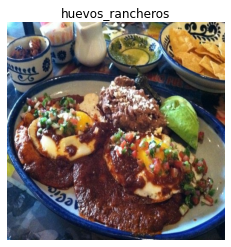

In [17]:
plt.imshow(image/255)
plt.title(class_names[label.numpy()])
plt.axis(False);

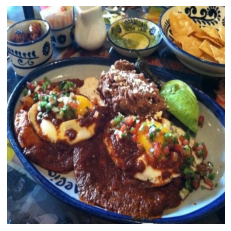

In [18]:
plt.imshow(image)
plt.axis(False);

Image shape: (384, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 56
    Class name (str form): huevos_rancheros
Image shape: (306, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 29
    Class name (str form): cup_cakes
Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 23
    Class name (str form): churros
Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 1
    Class name (str form): baby_back_ribs
Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 72
    Class name (str form): pancakes
Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 8
    Class name (str form): bread_pudding
Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 

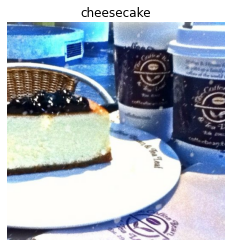

In [19]:
train_one_sample=[]
for i in range(10):
  train_one_sample.append(train_data.take(1))
  for image, label in train_one_sample[i]:
    plt.imshow(image/255)
    plt.title(class_names[label.numpy()])
    plt.axis(False);
    print(f"""Image shape: {image.shape} Image dtype: {image.dtype} Target class or Label from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}""")
  

In [20]:
train_one_sample= train_data.take(10)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

## Preprocessing function to preprocess our data

> Neural Network perform best when data is in a certain way(e.g. `batched, normalized, etc`)

> Before we pass, the data to the model for training, we need to do a few thing to the data for it to be eligiable to be passed to the model for training

### what are the problems with the data we have currently:-

* Images are in `uint8` datatype

* Images are of varying sizes

* Images are not scaled(between 0-1)

### What type of data, models like:

* Data needs to be in `float32` dtype(or for `mixed precision` in `float16 and float32`)

* For Batches, Tensorflow likes the images in a `constant/consistent/same size`.

* Normalized/scaled data(values between 0-1) speeds up the traning process and helps the model learn the patterns of the dataset faster

#### Working of the preprocessing function

* Reshaping all of the images to the same size
* Convert all of the dtypes of our image tensors from `uint8` to `float32` which models like.

In [21]:
def preprocess_image(image, label, img_shape=224, scaling=False):
  """
    Converts any image datatype to 'float32', and reshapes the images to [img_shape, img_shape, color_channels]
    Args:
      image: The image to the preprocesses
      label: string, The label of the image
      img_shape: int, Default is '224'. The shape to which the image is preprocessed into.
    Returns:
      (newImage, label) respectively as a tupel

  """
  image= tf.image.resize(image, [img_shape, img_shape]) # Resizing the image into a same size.
  if scaling:
    image= image/255. # Scaling/Normalizing values of the image. EfficientNetBx models have build-in rescaling layers
  newdtypeImage= tf.cast(image, tf.float32) # Changing the dtype of the image into float32
  return newdtypeImage, label

### Trying the preprocessed function

In [22]:
preprocessed_img, preprocessed_label= preprocess_image(image, label)

In [23]:
preprocessed_img

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 84.67857 ,  84.321434,  92.321434],
        [ 87.19898 ,  86.841835,  94.841835],
        [ 84.72959 ,  84.581635,  94.72449 ],
        ...,
        [119.50503 , 194.93877 , 245.85202 ],
        [114.974525, 190.97452 , 241.90309 ],
        [119.071465, 196.4286  , 247.82652 ]],

       [[ 75.647964,  84.21939 ,  93.21939 ],
        [ 71.45407 ,  80.959175,  89.959175],
        [ 78.03061 ,  87.20408 ,  97.47449 ],
        ...,
        [113.31632 , 182.62755 , 249.35715 ],
        [106.57655 , 176.86227 , 245.4337  ],
        [108.601944, 179.9796  , 248.16833 ]],

       [[129.9949  , 152.06633 , 171.49492 ],
        [149.87756 , 171.94899 , 192.66328 ],
        [156.43878 , 178.29593 , 201.22449 ],
        ...,
        [127.94895 , 184.08676 , 236.39796 ],
        [129.41847 , 186.4899  , 238.41847 ],
        [132.56607 , 191.07118 , 243.63744 ]],

       ...,

       [[ 68.23475 ,  72.091934,  90.73993 ],
        [ 67.

In [24]:
preprocessed_img_1, preprocessed_label_1= preprocess_image(image, label, scaling=False)

In [25]:
preprocessed_img_1

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 84.67857 ,  84.321434,  92.321434],
        [ 87.19898 ,  86.841835,  94.841835],
        [ 84.72959 ,  84.581635,  94.72449 ],
        ...,
        [119.50503 , 194.93877 , 245.85202 ],
        [114.974525, 190.97452 , 241.90309 ],
        [119.071465, 196.4286  , 247.82652 ]],

       [[ 75.647964,  84.21939 ,  93.21939 ],
        [ 71.45407 ,  80.959175,  89.959175],
        [ 78.03061 ,  87.20408 ,  97.47449 ],
        ...,
        [113.31632 , 182.62755 , 249.35715 ],
        [106.57655 , 176.86227 , 245.4337  ],
        [108.601944, 179.9796  , 248.16833 ]],

       [[129.9949  , 152.06633 , 171.49492 ],
        [149.87756 , 171.94899 , 192.66328 ],
        [156.43878 , 178.29593 , 201.22449 ],
        ...,
        [127.94895 , 184.08676 , 236.39796 ],
        [129.41847 , 186.4899  , 238.41847 ],
        [132.56607 , 191.07118 , 243.63744 ]],

       ...,

       [[ 68.23475 ,  72.091934,  90.73993 ],
        [ 67.

original Image
Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 16
    Class name (str form): cheesecake


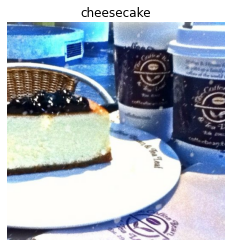

In [26]:
print("original Image")
plt.imshow(image)
plt.title(class_names[label.numpy()])
print(f"""Image shape: {image.shape} Image dtype: {image.dtype} Target class or Label from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}""")
plt.axis(False);

Preprocessed Image
Image shape: (224, 224, 3) Image dtype: <dtype: 'float32'> Target class or Label from Food101 (tensor form): 16
    Class name (str form): cheesecake


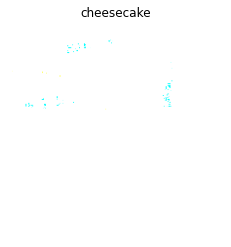

In [27]:
print("Preprocessed Image")
plt.imshow(preprocessed_img)
plt.title(class_names[label.numpy()])
print(f"""Image shape: {preprocessed_img.shape} Image dtype: {preprocessed_img.dtype} Target class or Label from Food101 (tensor form): {preprocessed_label}
    Class name (str form): {class_names[label.numpy()]}""")
plt.axis(False);

Preprocessed Image
Image shape: (224, 224, 3) Image dtype: <dtype: 'float32'> Target class or Label from Food101 (tensor form): 16
    Class name (str form): cheesecake


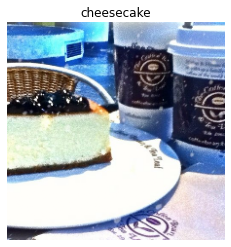

In [28]:
print("Preprocessed Image")
plt.imshow(preprocessed_img_1/255)
plt.title(class_names[label.numpy()])
print(f"""Image shape: {preprocessed_img_1.shape} Image dtype: {preprocessed_img_1.dtype} Target class or Label from Food101 (tensor form): {preprocessed_label_1}
    Class name (str form): {class_names[preprocessed_label_1.numpy()]}""")
plt.axis(False);

## Creating batches of the dataset and preparing the datasets

**Resources** -> https://www.tensorflow.org/guide/data_performance

In [29]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

## Explanation

"Hey, map this preprocessing function across our training dataset, then shuffle a number of elements before batching them together and make sure you prepare new batches (prefetch) whilst the model is looking through the current batc

In [30]:
# Mapped the preprocessing function to training data
train_data_processes= train_data.map(map_func= preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) # Tensorflow is going to automatically, tune the number of process the function uses.

# Shuffle train_data and turn it into batches and prefetch it(loading the data faster)
train_data_processes= train_data_processes.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) # It is going to shuffle 1000 sampples at a time

# Mapped the preprocessing function to test data
test_data_processes= test_data.map(map_func= preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)


In [31]:
train_data_processes

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [32]:
train_data_processes

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [33]:
train_data_processes

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Create Modelling callbacks

In [34]:
from helper_functions import  create_tensorboard_callback, model_check_point_callback, create_early_stopping_callback, reduce_learning_rate_callback

In [35]:
checkpoint_path= 'model_checkpoints/feature_extraction.ckpt'

In [36]:
tensorboard_callback= create_tensorboard_callback("transfer_learning", "101_classes_feature_extraction_all_data")
checkpoint_callback=model_check_point_callback(checkpoint_path, save_weights_only=True, save_best_only=True, monitor="val_loss")
early_stopping_callback= create_early_stopping_callback(monitor="val_loss", patience=5)
learning_rate_reduce_callback= reduce_learning_rate_callback(monitor="val_loss", factor=0.2, patience=2, minimum_lr=1e-7)

Saving TensorBoard log files to: transfer_learning/101_classes_feature_extraction_all_data/20220810-055949


## Mixed Precision Training

> Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.

**Guide** -> https://www.tensorflow.org/guide/mixed_precision

## Adding Augmented Layer

In [37]:
augmented_layer=create_data_augmented_layer_for_model(RandomFlip="horizontal", RandomRotation=0.2, RandomZoom=0.2, RandomHeight=0.2, RandomWidth=0.2)
augmented_layer

## Turnining on Mixed Precision Training


In [38]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [39]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [40]:
len(class_names)

101

In [41]:
CLASS_COUNT=len(class_names)

## Build Feature extraction model with `Dropout` and `Regularization` layers

In [ ]:
# # input_shape=(512, 512,3)
# input_shape=(224,224,3)
# base_model= tf.keras.applications.EfficientNetB0(include_top=False)
# base_model.trainable= False

# inputs= layers.Input(shape= input_shape, name="input_layer")
# # x= preprocessing.Rescaling(1./255)(x)
# x= augmented_layer(inputs)
# x= base_model(x, training=False)
# x= layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x= layers.Dense(units= CLASS_COUNT,kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4), activity_regularizer=regularizers.L2(1e-5))(x)
# x=layers.Dense(len(class_names))(x)
# outputs= layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
# model= tf.keras.Model(inputs, outputs)

# model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam())

In [ ]:
# model.summary()

## Checking the layers of the model

* `layer.name` -> Human readable name of the layer
* `layer.trainable` -> Boolean, layer is trainable or not, if the layers are frozen or unfrozen
* `layer.dtype` -> The dtype format in which the layer stores the variables in

* `layer.dtype_policy` -> The dype_policy in which the layer computes the variables in

In [ ]:
# for layer in model.layers:
#   print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

## Checking the layers of the base_model(EfficientNetB0)

In [ ]:
# for layer in base_model.layers[:20]: 
#   print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

In [ ]:
# for layer in model.layers[1].layers[:20]: 
#   print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

## Training the feature_extraction layer

In [ ]:
# history_feature_extraction= model.fit(train_data, epochs=15, steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=int(0.15 * len(test_data)), callbacks=[tensorboard_callback, checkpoint_callback, early_stopping_callback])

In [ ]:
# model.evaluate(test_data)

In [ ]:
# plot_loss_curves(history_feature_extraction)

In [ ]:
# result_feature_extraction= model.evaluate(test_data)
# result_feature_extraction

## Trying the model with increased batch size

> As we are using `Mixed precision` training and `float16` tensors use half the memory.

`BATCH_SIZE = 128`

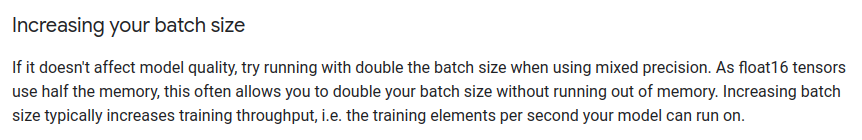

In [ ]:
# # Mapped the preprocessing function to training data
# train_data128= train_data.map(map_func= preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) # Tensorflow is going to automatically, tune the number of process the function uses.

# # Shuffle train_data and turn it into batches and prefetch it(loading the data faster)
# train_data128= train_data128.shuffle(buffer_size=1000).batch(batch_size=128).prefetch(buffer_size=tf.data.AUTOTUNE) # It is going to shuffle 1000 sampples at a time

# # Mapped the preprocessing function to test data
# test_data128= test_data.map(map_func= preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(128).prefetch(tf.data.AUTOTUNE)


In [ ]:
# # input_shape=(512, 512,3)
# input_shape=(224,224,3)
# base_model= tf.keras.applications.EfficientNetB0(include_top=False)
# base_model.trainable= False

# inputs= layers.Input(shape= input_shape, name="input_layer")
# # x= preprocessing.Rescaling(1./255)(x)
# x= base_model(inputs, training=False)
# x= layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x=layers.Dense(len(class_names))(x)
# outputs= layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
# model_128= tf.keras.Model(inputs, outputs)

# model_128.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam())

# history_feature_extraction_128= model_128.fit(train_data, epochs=15, steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=int(0.15 * len(test_data)), callbacks=[tensorboard_callback, checkpoint_callback, early_stopping_callback])

## Running the model without `Dropout` and `Regularization` layers added

In [ ]:
# # Mapped the preprocessing function to training data
# train_data= train_data.map(map_func= preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) # Tensorflow is going to automatically, tune the number of process the function uses.

# # Shuffle train_data and turn it into batches and prefetch it(loading the data faster)
# train_data= train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) # It is going to shuffle 1000 sampples at a time

# # Mapped the preprocessing function to test data
# test_data= test_data.map(map_func= preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# # input_shape=(512, 512,3)
# input_shape=(224,224,3)
# base_model= tf.keras.applications.EfficientNetB0(include_top=False)
# base_model.trainable= False

# inputs= layers.Input(shape= input_shape, name="input_layer")
# # x= preprocessing.Rescaling(1./255)(x)
# x= base_model(inputs, training=False)
# x= layers.GlobalAveragePooling2D()(x)
# x=layers.Dense(len(class_names))(x)
# outputs= layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
# model_1= tf.keras.Model(inputs, outputs)

# model_1.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam())

# history_feature_extraction_1= model_1.fit(train_data_processes, epochs=15, steps_per_epoch=len(train_data_processes), validation_data=test_data_processes, validation_steps=int(0.15 * len(test_data_processes)), callbacks=[tensorboard_callback, checkpoint_callback, learning_rate_reduce_callback])
# # history_feature_extraction_1= model_1.fit(train_data_processes, epochs=15, steps_per_epoch=len(train_data_processes), validation_data=test_data_processes, validation_steps=int(0.15 * len(test_data_processes)), callbacks=[tensorboard_callback, checkpoint_callback, early_stopping_callback, learning_rate_reduce_callback])

In [ ]:
# model_1.evaluate(test_data_processes)

In [ ]:
# result_feature_extraction_1=model_1.evaluate(test_data_processes)
# result_feature_extraction_1

In [ ]:
# plot_loss_curves(history_feature_extraction_1)

## With Early Stopping Callback added

In [42]:
# input_shape=(512, 512,3)
input_shape=(224,224,3)
base_model= tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable= False

inputs= layers.Input(shape= input_shape, name="input_layer")
# x= preprocessing.Rescaling(1./255)(x)
x= base_model(inputs, training=False)
x= layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x=layers.Dense(len(class_names))(x)
outputs= layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model_2= tf.keras.Model(inputs, outputs)

model_2.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam())

history_feature_extraction_2= model_2.fit(train_data_processes, epochs=100, steps_per_epoch=len(train_data_processes), validation_data=test_data_processes, validation_steps=int(0.15 * len(test_data_processes)), callbacks=[tensorboard_callback, checkpoint_callback, early_stopping_callback, learning_rate_reduce_callback])

16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 1.8214 - accuracy: 0.5571
Epoch 1: val_loss improved from inf to 1.22762, saving model to model_checkpoints/feature_extraction.ckpt
2368/2368 [==============================] - 183s 70ms/step - loss: 1.8214 - accuracy: 0.5571 - val_loss: 1.2276 - val_accuracy: 0.6803 - lr: 0.0010
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 1.2933 - accuracy: 0.6655
Epoch 2: val_loss improved from 1.22762 to 1.12085, saving model to model_checkpoints/feature_extraction.ckpt
2368/2368 [==============================] - 163s 68ms/step - loss: 1.2933 - accuracy: 0.6655 - val_loss: 1.1208 - val_accuracy: 0.7007 - lr: 0.0010
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 1.1420 - accuracy: 0.7028
Epoch 3: val_loss improved from 1.12085 to 1.10413, saving model to model_checkpoints/feature_extraction.ckpt
2368/2368 [===

In [59]:
result_model_2=model_2.evaluate(test_data_processes)
result_model_2

790/790 [==============================] - 47s 59ms/step - loss: 1.0539 - accuracy: 0.7161


[1.0539318323135376, 0.7160792350769043]

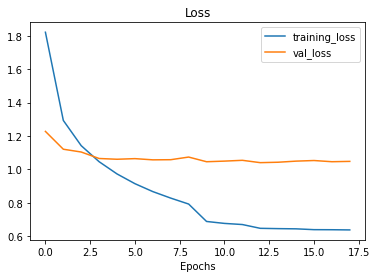

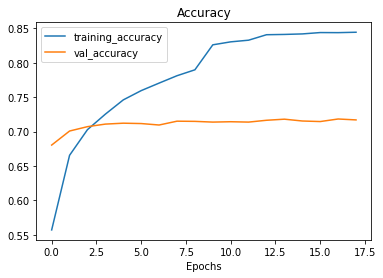

In [44]:
plot_loss_curves(history_feature_extraction_2)

In [45]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Saving the model

In [ ]:
# model.save('saved_models/model_feature_extraction_1')

In [ ]:
# model_1.save('saved_models/model_feature_extraction_1')

In [46]:
# model_2.save('saved_models/model_feature_extraction_2')

INFO:tensorflow:Assets written to: saved_models/model_feature_extraction_2/assets


INFO:tensorflow:Assets written to: saved_models/model_feature_extraction_2/assets


## Downloading the saved models

In [ ]:
!zip -r /content/saved_models.zip /content/saved_models

  adding: content/saved_models/ (stored 0%)
  adding: content/saved_models/model_feature_extraction_2/ (stored 0%)
  adding: content/saved_models/model_feature_extraction_2/saved_model.pb (deflated 91%)
  adding: content/saved_models/model_feature_extraction_2/variables/ (stored 0%)
  adding: content/saved_models/model_feature_extraction_2/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/saved_models/model_feature_extraction_2/variables/variables.index (deflated 73%)
  adding: content/saved_models/model_feature_extraction_2/keras_metadata.pb (deflated 96%)
  adding: content/saved_models/model_feature_extraction_2/assets/ (stored 0%)


In [ ]:
from google.colab import files
files.download('/content/saved_models.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Checking the dtype_policy of the layer of the base_model

In [47]:
for layer in base_model.layers:
  print(layer, layer.name, layer.dtype, layer.dtype_policy)

<keras.engine.input_layer.InputLayer object at 0x7fa826348410> input_1 float32 <Policy "float32">
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fa82304cfd0> rescaling float32 <Policy "mixed_float16">
<keras.layers.preprocessing.normalization.Normalization object at 0x7fa822d9a550> normalization float32 <Policy "mixed_float16">
<keras.layers.convolutional.ZeroPadding2D object at 0x7fa823031050> stem_conv_pad float32 <Policy "mixed_float16">
<keras.layers.convolutional.Conv2D object at 0x7fa822a78950> stem_conv float32 <Policy "mixed_float16">
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa822d65cd0> stem_bn float32 <Policy "mixed_float16">
<keras.layers.core.activation.Activation object at 0x7fa822a7fc90> stem_activation float32 <Policy "mixed_float16">
<keras.layers.convolutional.DepthwiseConv2D object at 0x7fa8225999d0> block1a_dwconv float32 <Policy "mixed_float16">
<keras.layers.normalization.batch_normalization.BatchNormal

## Loading and Evaluating checkpoint weights

In [ ]:
# loaded_model= tf.keras.models.load_model('/content/saved_models/model_feature_extraction_2')

In [48]:
loaded_model= tf.keras.models.clone_model(model_2)
loaded_model

In [49]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [63]:
checkpoint_path

'model_checkpoints/feature_extraction.ckpt'

In [50]:
loaded_model.load_weights(checkpoint_path)

## Recompile the model

> Whenever we make any change to the model, including the weights, we have to recompile the model.

In [51]:
loaded_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [52]:
loaded_model_result=loaded_model.evaluate(test_data_processes)
loaded_model_result

790/790 [==============================] - 49s 59ms/step - loss: 1.7441 - accuracy: 0.5563


[1.7441370487213135, 0.5563168525695801]

In [57]:
result_model_2

[1.0539321899414062, 0.7160792350769043]

## Checking if the model saved/loaded correctly

In [58]:
loaded_model_result == result_model_2

False

In [61]:
np.allclose(result_model_2,loaded_model_result)

False

In [62]:
np.isclose(result_model_2,loaded_model_result)

array([False, False])

## Saving the model

In [64]:
model_2.save('saved_models/model_feature_extraction_2')

INFO:tensorflow:Assets written to: saved_models/model_feature_extraction_2/assets


INFO:tensorflow:Assets written to: saved_models/model_feature_extraction_2/assets


## loading the feature extraction model

In [66]:
loaded_model_2= tf.keras.models.load_model('saved_models/model_feature_extraction_2')

In [68]:
result_loaded_model_2= loaded_model_2.evaluate(test_data_processes)
result_loaded_model_2

790/790 [==============================] - 64s 78ms/step - loss: 1.0539 - accuracy: 0.7161


[1.0539323091506958, 0.7160792350769043]

In [69]:
np.allclose(result_model_2, result_loaded_model_2)

True

## Preparing for Fine-Tuning of the model

> Let's start by unfreezing `10` layers from the base_model

In [ ]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

### Unfreezing `10` layers for Fine-Tuning

In [ ]:
# base_model.trainable= True

# for layer in base_model.layers[:-10]:
#   layer.trainable=False

# loaded_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

In [ ]:
# for layer in base_model.layers:
#   if layer.trainable == True:
#     print(layer, layer.name)

## Callback for Fine-Tuning

In [ ]:
# checkpoint_callback_fine_tuning=model_check_point_callback("checkpoints_fine_tuning", save_weights_only=True, save_best_only=True, monitor="val_loss")
# tensorboard_callback_fine_tuning= create_tensorboard_callback("transfer_learning", "101_classes_fine_tuning_all_data")
# early_stopping_callback_fine_tuning= create_early_stopping_callback(monitor="val_loss", patience=3)

## Fine-Tuning the model

In [ ]:
# initial_epochs=15
# fine_tune_epochs= initial_epochs + 15
# history_fine_tuned_10_unfrozen= loaded_model.fit(train_data, epochs=fine_tune_epochs, initial_epoch=history_feature_extraction_1.epoch[-1] ,steps_per_epoch=len(train_data) ,validation_data= test_data, validation_steps=int(0.15 * len(test_data)), callbacks=[checkpoint_callback_fine_tuning, tensorboard_callback_fine_tuning, early_stopping_callback_fine_tuning])

In [ ]:
# loaded_model.save("saved_models/fine_tuned_model_1")

In [ ]:
# !zip -r /content/saved_models.zip /content/saved_models

In [ ]:
from google.colab import files
files.download('/content/saved_models.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# loaded_model.evaluate(test_data)

In [ ]:
# result_fine_tuned_1=loaded_model.evaluate(test_data)
# result_fine_tuned_1

In [ ]:
# compare_historys(history_feature_extraction_1, history_fine_tuned_10_unfrozen)

In [ ]:
# loaded_model.summary()

## Load the saved Feature Extraction Model

In [ ]:
# loaded_model_2= tf.keras.models.load_model('/content/saved_models/model_feature_extraction_2')

In [70]:
loaded_model_2= tf.keras.models.clone_model(model_2)
loaded_model_2

In [71]:
loaded_model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [73]:
loaded_model_2.load_weights(checkpoint_path)

## Recompile the model

> Whenever we make any change to the model, including the weights, we have to recompile the model.

In [74]:
loaded_model_2.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [75]:
result_loaded_model_2 = loaded_model_2.evaluate(test_data_processes)
result_loaded_model_2

790/790 [==============================] - 51s 61ms/step - loss: 1.7441 - accuracy: 0.5563


[1.7441375255584717, 0.5563168525695801]

In [76]:
np.allclose(result_model_2, result_loaded_model_2)

False

## Loading the saved Model

In [77]:
loaded_model_3= tf.keras.models.load_model('saved_models/model_feature_extraction_2')

In [78]:
result_loaded_model_3= loaded_model_3.evaluate(test_data_processes)
result_loaded_model_3

790/790 [==============================] - 66s 78ms/step - loss: 1.0539 - accuracy: 0.7161


[1.0539319515228271, 0.7160792350769043]

In [79]:
np.allclose(result_model_2, result_loaded_model_3)

True

## Saving the model

In [80]:
# save_dir = "efficientnetb0_feature_extract_model_mixed_precision"
# loaded_model_3.save(save_dir)

INFO:tensorflow:Assets written to: efficientnetb0_feature_extract_model_mixed_precision/assets


INFO:tensorflow:Assets written to: efficientnetb0_feature_extract_model_mixed_precision/assets


## Loading saved model

In [ ]:
# loaded_model_3= tf.keras.models.load_model(save_dir)

In [ ]:
# result_loaded_model_3=loaded_model_3.evaluate(test_data_processes)
# result_loaded_model_3

In [ ]:
# np.allclose(result_model_2, result_loaded_model_3)

In [81]:
loaded_model_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Create Fine-Tune Model with all unfrozen layers

In [83]:
loaded_model_3.layers

## UnFreezing all the layers of the base_model(EfficientNetb0)

In [84]:
for layer in loaded_model_3.layers:
  layer.trainable= True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [87]:
for layer in loaded_model_3.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed

In [91]:
# base_model.layers, base_model.layers.trainable

AttributeError: ignored

In [94]:
for layer in loaded_model_3.layers:
  if layer.trainable == True:
    print(layer, layer.name)

<keras.engine.input_layer.InputLayer object at 0x7fa785b57f90> input_layer
<keras.engine.functional.Functional object at 0x7fa78560f790> efficientnetb0
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fa7855583d0> pooling_layer
<keras.layers.core.dense.Dense object at 0x7fa785558d50> dense
<keras.layers.core.activation.Activation object at 0x7fa785559810> softmax_float32


In [93]:
for layer in loaded_model_3.layers[1].layers:
  if layer.trainable == True:
    print(layer, layer.name)

<keras.engine.input_layer.InputLayer object at 0x7fa785559c50> input_1
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fa78555d790> rescaling
<keras.layers.preprocessing.normalization.Normalization object at 0x7fa78555dc90> normalization
<keras.layers.convolutional.ZeroPadding2D object at 0x7fa785561e90> stem_conv_pad
<keras.layers.convolutional.Conv2D object at 0x7fa785566750> stem_conv
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa78556bf50> stem_bn
<keras.layers.core.activation.Activation object at 0x7fa78556ff90> stem_activation
<keras.layers.convolutional.DepthwiseConv2D object at 0x7fa785575510> block1a_dwconv
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa785579e10> block1a_bn
<keras.layers.core.activation.Activation object at 0x7fa78557ddd0> block1a_activation
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fa7855024d0> block1a_se_squeeze
<keras.layers.core.reshape.Reshape ob

In [95]:
for layer in base_model.layers:
  if layer.trainable == False:
    print(layer, layer.name)

<keras.engine.input_layer.InputLayer object at 0x7fa826348410> input_1
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fa82304cfd0> rescaling
<keras.layers.preprocessing.normalization.Normalization object at 0x7fa822d9a550> normalization
<keras.layers.convolutional.ZeroPadding2D object at 0x7fa823031050> stem_conv_pad
<keras.layers.convolutional.Conv2D object at 0x7fa822a78950> stem_conv
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa822d65cd0> stem_bn
<keras.layers.core.activation.Activation object at 0x7fa822a7fc90> stem_activation
<keras.layers.convolutional.DepthwiseConv2D object at 0x7fa8225999d0> block1a_dwconv
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa822c29c90> block1a_bn
<keras.layers.core.activation.Activation object at 0x7fa822574910> block1a_activation
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fa822d9ab50> block1a_se_squeeze
<keras.layers.core.reshape.Reshape ob

In [96]:
for layer in loaded_model_3.layers:
  if layer.trainable == False:
    print(layer, layer.name)

In [98]:
len(loaded_model_3.layers)

5

In [99]:
len(loaded_model_3.trainable_variables)

213

In [100]:
len(base_model.trainable_variables)

0

In [101]:
len(base_model.layers)

237

In [ ]:
for layer in base_model.layers:
  if layer.trainable == False:
    print(layer, layer.name)

## Callback for Fine-Tuning All unfrozen layers

In [104]:
checkpoint_path_fine_tuning= 'model_fine_tuning_checkpoints/checkpoints_fine_tuning_all.ckpt'
checkpoint_callback_fine_tuning_all_unfrozen=model_check_point_callback(checkpoint_path_fine_tuning, save_weights_only=True, save_best_only=True, monitor="val_accuracy")
tensorboard_callback_fine_tuning_all_unfrozen= create_tensorboard_callback("transfer_learning", "101_classes_fine_tuning_all_data_all_unfrozen_layers")
early_stopping_callback_fine_tuning_all_unfrozen= create_early_stopping_callback(monitor="val_loss", patience=5)
learning_rate_reduce_callback_all_unfrozen= reduce_learning_rate_callback(monitor="val_loss", factor=0.2, patience=2, minimum_lr=1e-7)

Saving TensorBoard log files to: transfer_learning/101_classes_fine_tuning_all_data_all_unfrozen_layers/20220810-071813


## Compiling the model for Fine-Tuning

In [105]:
loaded_model_3.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001))

## Fine-Tuning for all unfrozen layers

In [106]:
history_fine_tuned_all= loaded_model_3.fit(train_data_processes, epochs=100, steps_per_epoch=len(train_data_processes) ,validation_data= test_data_processes, validation_steps=int(0.15 * len(test_data_processes)), callbacks=[checkpoint_callback_fine_tuning_all_unfrozen, tensorboard_callback_fine_tuning_all_unfrozen, early_stopping_callback_fine_tuning_all_unfrozen, learning_rate_reduce_callback_all_unfrozen])

Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.7566 - accuracy: 0.7883
Epoch 1: val_accuracy improved from -inf to 0.75397, saving model to model_fine_tuning_checkpoints/checkpoints_fine_tuning_all.ckpt
2368/2368 [==============================] - 359s 144ms/step - loss: 0.7566 - accuracy: 0.7883 - val_loss: 0.9419 - val_accuracy: 0.7540 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.4454 - accuracy: 0.8723
Epoch 2: val_accuracy improved from 0.75397 to 0.75768, saving model to model_fine_tuning_checkpoints/checkpoints_fine_tuning_all.ckpt
2368/2368 [==============================] - 341s 143ms/step - loss: 0.4454 - accuracy: 0.8723 - val_loss: 0.9526 - val_accuracy: 0.7577 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.2450 - accuracy: 0.9278
Epoch 3: val_accuracy improved from 0.75768 to 0.76589, saving model to model_fine_tuning_checkpoints/checkpoints_fine_tuning_al

In [107]:
result_loaded_model_3=loaded_model_3.evaluate(test_data_processes)
result_loaded_model_3

790/790 [==============================] - 52s 65ms/step - loss: 1.3087 - accuracy: 0.7810


[1.3086647987365723, 0.7809504866600037]

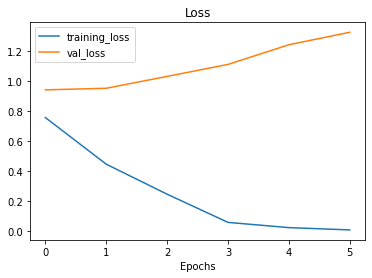

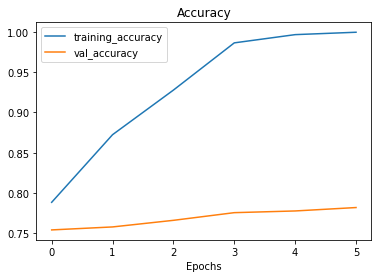

In [108]:
plot_loss_curves(history_fine_tuned_all)

In [ ]:
# result_fine_tuned_1

In [ ]:
# compare_historys(history_feature_extraction_1, history_fine_tuned_all)

In [ ]:
# compare_historys(history_feature_extraction_1, history_fine_tuned_10_unfrozen)

## Saving the Fine-Tuned Model

In [109]:
loaded_model_3.save('saved_models/fine_tuned_model_3')

INFO:tensorflow:Assets written to: saved_models/fine_tuned_model_3/assets


INFO:tensorflow:Assets written to: saved_models/fine_tuned_model_3/assets


## Loading saved model

In [111]:
loaded_fine_tuned_model= tf.keras.models.load_model('saved_models/fine_tuned_model_3')

## Viewing/Comparing results on tensorboard


Link -> https://tensorboard.dev/experiment/8RDC0W82QkCB22MQyuYhag/#scalars

In [ ]:
# !tensorboard dev upload --logdir ./transfer_learning \
# --name "Transfer Learning on the Food101 dataset" \
# --description "Training a Transfer Learning model with EfficientNetB0 to beat the DeepFood paper which is based on the Food101 dataset." \
# --one_shot

In [ ]:
# !tensorboard dev list

## Evaluating `loaded_model_2`

In [ ]:
pred_probs=loaded_model_2.predict(test_data_processes, verbose=1)

In [ ]:
len(pred_probs)

In [ ]:
pred_probs.shape

In [ ]:
pred_probs[1]

In [ ]:
pred_classes= pred_probs.argmax(axis=1)

pred_classes[:5]

In [ ]:
len(pred_classes)

In [ ]:
y_labels= []

for images, labels in test_data_processes.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels

In [ ]:
len(y_labels)

## Accuracy Score

In [ ]:
sklearn_accuracy= accuracy_score(y_true= y_labels, y_pred= pred_classes)
sklearn_accuracy

## Confusion Matrix

In [ ]:
cm = confusion_matrix(y_labels, pred_classes)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]==0
fig, ax = plt.subplots(figsize=(100,100))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Classification Report 

In [ ]:
print(classification_report(y_true= y_labels, y_pred= pred_classes))

In [ ]:
classification_report_dict= classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

## Visualizing the F1-score

In [ ]:
class_f1_scores= {}

# Looping through the classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break

  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]


class_f1_scores

In [ ]:
f1_scores= pd.DataFrame({"class_names": list(class_f1_scores.keys()), "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_names"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## Making Predictions on a series of random images

In [ ]:
train_dir='101_food_classes_10_percent/train'
test_dir='101_food_classes_10_percent/test'

In [ ]:
plt.figure(figsize=(40,10))
for i in range(15):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  img_expanded=tf.expand_dims(img, axis=0)
  pred_prob = model_final.predict(img_expanded) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(3, 5, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predictions

In [ ]:
filepaths= []

for path in test_data.list_files('/content/101_food_classes_10_percent/test/*/*.jpg', shuffle= False):

  filepaths.append(path.numpy())

In [ ]:
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

In [ ]:
wrong_pred_df= pred_df[pred_df['pred_correct'] == False].sort_values("pred_conf", ascending=False)
wrong_pred_df

In [ ]:
images_to_view = 15
start_index = 32 # change the start index to view more
plt.figure(figsize=(30, 20))
for i, row in enumerate(wrong_pred_df[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 5, i+1)
  img = load_and_prep_image(row[1], scale=True) # 'row[1]' gives you the img path
  _, _, _, _, pred_conf, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \n prob: {pred_conf:.2f}")
  plt.axis(False)

## Evaluating on custom dataset

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

In [ ]:
unzip_data('custom_food_images.zip')

In [ ]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

In [ ]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model_final.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)